In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt

# Анализ убытков компании Procrastinate Pro+

- [Описание проекта](#project_description)
- [Описание, загрузка и подготовка данных](#data)
- [Функции для расчета и анализа конверсии, удержания, LTV и ROI](#functions)
- [Исследовательский анализ данных](#EDA)
- [Маркетинг](#marketing)
- [Оценка окупаемости рекламы](#advertising_evaluation)
    - [Окупаемость рекламы](#roi)
    - [Окупаемость рекламы с разбивкой по устройствам](#roi_by_device)
    - [Окупаемость рекламы с разбивкой по странам](#roi_by_country)
    - [Окупаемость рекламы с разбивкой по рекламным каналам](#roi_by_channel)
    - [Конверсия и удержание](#c_r)
    - [Конверсия и удержание с разбивкой по устройствам](#c_r_by_device)
    - [Конверсия и удержание с разбивкой по старнам](#c_r_by_country)
    - [Конверсия и удержание с разбивкой по рекламным каналам](#c_r_by_channel)
    - [Окупаемость рекламых каналов в США](#USA)
- [Вывод](#conclusion)

## Описание проекта <a name='project_description'></a>

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

## Описание, загрузка и подготовка данных <a name='data'></a>

In [2]:
visits = pd.read_csv('datasets/visits_info_short.csv')
visits = visits.rename(columns={
    'User Id': 'user_id',
    'Region': 'region',
    'Device': 'device',
    'Channel': 'channel',
    'Session Start': 'session_start',
    'Session End': 'session_end'
})

orders = pd.read_csv('datasets/orders_info_short.csv')
orders = orders.rename(columns={
    'User Id': 'user_id',
    'Event Dt': 'event_dt',
    'Revenue': 'revenue'
})

costs = pd.read_csv('datasets/costs_info_short.csv')
costs = costs.rename(columns={
    'dt': 'date',
    'Channel': 'channel'
})

<br>

Таблица `visits` (информация о посещениях сайта):

* `user_id` – уникальный идентификатор пользователя

* `region` – страна пользователя

* `device` – тип устройства пользователя

* `channel` – источник перехода

* `session_start` – дата и время начала сессии

* `session_end` – дата и время окончания сессии

In [3]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.shape

(309901, 6)

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Приведем столбцы `session_start` и `session_end` к типу `datetime`.

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [7]:
visits.duplicated().sum()

0

Дубликатов нет.

<br>

Таблица `orders` (информация о покупках):

* `user_id` – уникальный идентификатор пользователя

* `event_dt` – дата и время покупки

* `revenue` – сумма заказа

In [8]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
orders.shape

(40212, 3)

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Приведем столбец `event_dt` к типу `datetime`.

In [11]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [12]:
orders.duplicated().sum()

0

Дубликатов нет.

<br>

Таблица `costs` (информация о расходах на рекламу):

* `dt` – дата проведения рекламной кампании

* `channel` – источник привлечения

* `costs` – расходы на рекламную кампанию

In [13]:
costs.head()

,date,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [14]:
costs.shape

(1800, 3)

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Приведем столбец `date` к типу `datetime`.

In [16]:
costs['date'] = pd.to_datetime(costs['date']).dt.date

In [17]:
costs.duplicated().sum()

0

Дубликатов нет.

## Функции для расчета и анализа конверсии, удержания, LTV и ROI <a name='functions'></a>

In [18]:
def get_profiles(visits, orders, costs):
    profiles = (
        visits
        .sort_values(['user_id', 'session_start'])
        .groupby('user_id', as_index=False)
        .agg({
            'session_start': 'first',
            'region': 'first',
            'device': 'first',
            'channel': 'first'
        })
        .rename(columns={'session_start': 'first_dt'})
    )
    profiles['date'] = profiles['first_dt'].dt.date
    profiles['month'] = profiles['first_dt'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles
        .groupby(['date', 'channel'], as_index=False)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'nunique_users'})
    )

    costs = costs.merge(new_users, on=['date', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['nunique_users']
    
    profiles = profiles.merge(
        costs[['date', 'channel', 'acquisition_cost']],
        on=['date', 'channel'],
        how='left'
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [19]:
def get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days-1)
    retention_raw = profiles[profiles['date'] <= last_suitable_acquisition_date]
    
    retention_raw = retention_raw.merge(
        visits[['user_id', 'session_start']],
        on='user_id',
        how='left'
    )
    retention_raw['lifetime'] = (retention_raw['session_start'] - retention_raw['first_dt']).dt.days
    
    dimensions = ['payer'] + dimensions
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='user_id',
            aggfunc='nunique'
        )
        cohort_sizes = (
            df
            .groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    retention = group_by_dimensions(retention_raw, dimensions, horizon_days)
    retention_history = group_by_dimensions(retention_raw, dimensions + ['date'], horizon_days)
    
    return retention_raw, retention, retention_history

In [20]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days-1)
    conversion_raw = profiles[profiles['date'] <= last_suitable_acquisition_date]
    
    first_orders = (
        orders
        .sort_values(['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
    conversion_raw = conversion_raw.merge(
        first_orders[['user_id', 'event_dt']],
        on='user_id',
        how='left'
    )
    
    conversion_raw['lifetime'] = (conversion_raw['event_dt'] - conversion_raw['first_dt']).dt.days
    
    if len(dimensions) == 0:
        conversion_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='user_id',
            aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df
            .groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    conversion = group_by_dimensions(conversion_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    conversion_history = group_by_dimensions(conversion_raw, dimensions + ['date'], horizon_days)
    
    return conversion_raw, conversion, conversion_history

In [21]:
def get_ltv_and_roi(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days-1)
    ltv_raw = profiles[profiles['date'] <= last_suitable_acquisition_date]
    
    ltv_raw = ltv_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left'
    )
    ltv_raw['lifetime'] = (ltv_raw['event_dt'] - ltv_raw['first_dt']).dt.days
    
    if len(dimensions) == 0:
        ltv_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions(df, dims, horizon_days):
        ltv = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum'
        )
        ltv = ltv.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df
            .groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        ltv = cohort_sizes.merge(ltv, on=dims, how='left').fillna(0)
        ltv = ltv.div(ltv['cohort_size'], axis=0)
        ltv = ltv[['cohort_size'] + list(range(horizon_days))]
        ltv['cohort_size'] = cohort_sizes
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac
            .groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        roi = ltv.div(cac['cac'], axis=0)
        roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        return ltv, roi
    
    ltv, roi = group_by_dimensions(ltv_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    ltv_history, roi_history = group_by_dimensions(
        ltv_raw, dimensions + ['date'], horizon_days
    )
    
    return ltv_raw, ltv, ltv_history, roi, roi_history

In [22]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [23]:
def plot_retention(retention, retention_history, horizon, window):
    plt.figure(figsize=(15, 10))
    
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon-1]]
    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
        
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    
    columns = [name for name in retention_history.index.names if name not in ['date', 'payer']]
    
    ax3 = plt.subplot(2, 2, 3)
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='date', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика удержания платящих пользователей на {horizon}-й день')
    
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='date', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика удержания неплатящих пользователей на {horizon}-й день')
    
    plt.tight_layout()
    plt.show() 

In [24]:
def plot_conversion(conversion, conversion_history, horizon, window):
    plt.figure(figsize=(15, 5))
    
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon-1]]
    
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['date']]
    filtered_data = conversion_history.pivot_table(
        index='date', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика конверсии пользователей на {horizon}-й день')
    
    plt.tight_layout()
    plt.show()

In [25]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window):
    plt.figure(figsize=(20, 10))
    
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    cac_history = roi_history[['cac']]
    
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]
    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['date']]
    filtered_data = ltv_history.pivot_table(
        index='date', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика LTV пользователей на {horizon}-день')
    
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['date']]
    filtered_data = cac_history.pivot_table(
        index='date', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['date']]
    filtered_data = roi_history.pivot_table(
        index='date', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика ROI пользователей на {horizon}-й день')
    
    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных <a name='EDA'></a>

In [26]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_dt,region,device,channel,date,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,United States,iPhone,FaceBoom,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,France,iPhone,organic,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,Germany,PC,AdNonSense,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,United States,iPhone,YRabbit,2019-10-02,2019-10-01,False,0.230769


In [27]:
min_date = profiles['date'].min()
max_date = profiles['date'].max()
print(f'Пользователи были привлеченены с {min_date} по {max_date}.')

Пользователи были привлеченены с 2019-05-01 по 2019-10-27.


In [28]:
def get_users_and_payers_info(profiles, by):
    result = (
        profiles
        .groupby(by)
        .agg({'user_id': 'count', 'payer': 'mean'})
        .rename(columns={'user_id': 'num of users', 'payer': '% of payers'})
        .sort_values('% of payers', ascending=False)
    )
    result['% of payers'] = result['% of payers'] * 100
    return result

In [29]:
get_users_and_payers_info(profiles, 'region')

,num of users,% of payers
region,,
United States,100002,6.901862
Germany,14981,4.111875
UK,17575,3.982930
France,17450,3.799427


2/3 пользователей приходит из США, также на эту страну приходится больше всего платящих пользователей.

In [30]:
get_users_and_payers_info(profiles, 'device')

,num of users,% of payers
device,,
Mac,30042,6.364423
iPhone,54479,6.207897
Android,35032,5.851793
PC,30455,5.046790


Чаще всего в приложение приходят пользователи мобильных устройств. Наиболее платящие пользователи – владельцы устройств от Apple.

In [31]:
get_users_and_payers_info(profiles, 'channel').sort_values(by='num of users', ascending=False)

,num of users,% of payers
channel,,
organic,56439,2.055316
FaceBoom,29144,12.204914
TipTop,19561,9.600736
OppleCreativeMedia,8605,2.707728
WahooNetBanner,8553,5.296387
LeapBob,8553,3.063253
RocketSuperAds,4448,7.913669
MediaTornado,4364,3.574702
YRabbit,4312,3.826531


Топ-3 канала по количеству привлеченных пользователей – органический, FaceBoom и TipTop. У органики самая низкая конверсия, а у FaceBoom и TipTop – одна из самых высоких. Интересно, что у каналов AdNonSense и lambdaMediaAds, из которых пришло наименьшее количество пользователей, конверсия на уровне с FaceBoom и TipTop.

In [32]:
channel_users = visits.groupby(['channel', 'region'])['user_id'].count()
channel_users = (
    channel_users
    .groupby(level=0)
    .apply(lambda x: round(100 * x / sum(x), 2))
    .to_frame()
    .rename(columns={'user_id': '% of users'})
)
channel_users

% of users
channel            region                   
AdNonSense         France              34.55
                   Germany             31.68
                   UK                  33.77
FaceBoom           United States      100.00
LeapBob            France              34.50
                   Germany             28.75
                   UK                  36.75
MediaTornado       United States      100.00
OppleCreativeMedia France              34.58
                   Germany             28.97
                   UK                  36.45
RocketSuperAds     United States      100.00
TipTop             United States      100.00
WahooNetBanner     France              34.37
                   Germany             30.90
                   UK                  34.73
YRabbit            United States      100.00
lambdaMediaAds     France              34.44
                   Germany             30.37
                   UK                  35.19
organic            France              11.20
                   Germany              9.76
                   UK                  11.43
                   United States       67.61

Исключая органику, можно разделить каналы на два типа:
    
* Привлекающие только пользователей из США

* Привлекающие европейских пользователей (доли по странам распределены равномерно)

## Маркетинг <a name='marketing'></a>

In [33]:
print('Всего на рекламу было потрачено: {:.2f}'.format(costs['costs'].sum()))

Всего на рекламу было потрачено: 105497.30


In [34]:
channel_costs = costs.groupby('channel')['costs'].sum().sort_values(ascending=False).to_frame()
channel_costs['% costs'] = round(channel_costs['costs'] * 100 / sum(channel_costs['costs']), 2)
channel_costs

,costs,% costs
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


83% рекламного бюджета приходится на каналы TipTop и FaceBoom. Расходы на канал TipTop больше, в то время как конверсия у канала FaceBoom лучше.

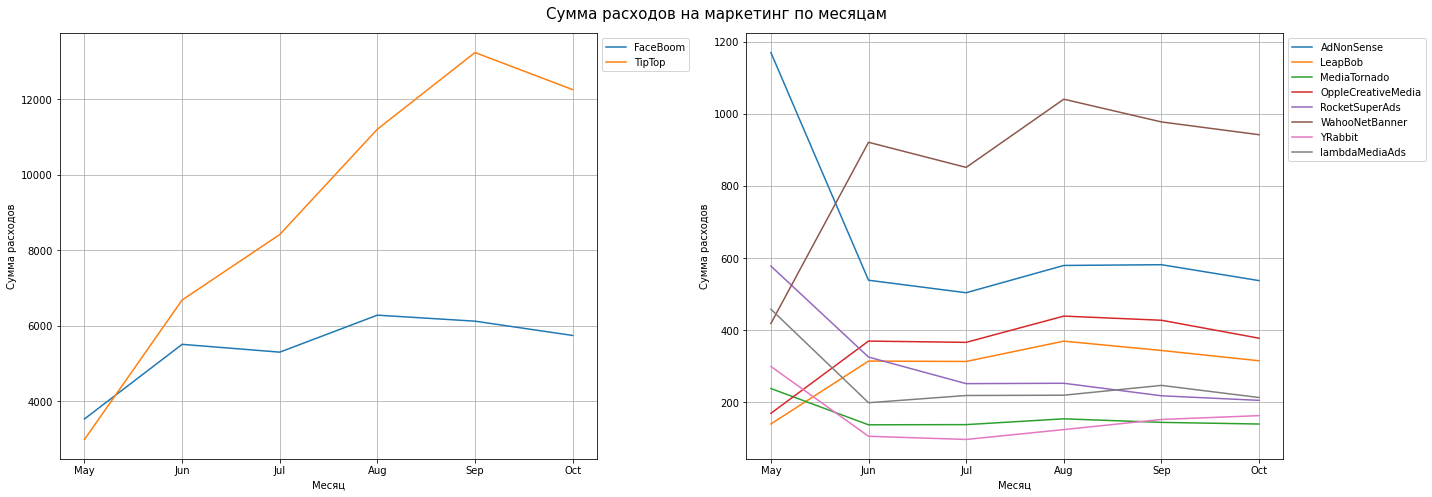

In [35]:
costs['month_number'] = pd.to_datetime(costs['date']).dt.month
costs['month_name'] = costs['month_number'].apply(lambda month_number: calendar.month_abbr[month_number])

channel_costs_by_month = (
    costs
    .pivot_table(index=['month_number', 'month_name'], columns='channel', values='costs', aggfunc='sum')
    .droplevel(0)
)

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
for channel in channel_costs_by_month.columns:
    j = 0 if channel in ['TipTop', 'FaceBoom'] else 1
    axes[j].plot(channel_costs_by_month[channel].index, channel_costs_by_month[channel].values, label=channel)
    axes[j].set_xlabel('Месяц')
    axes[j].set_ylabel('Сумма расходов')
    axes[j].grid(True)
    axes[j].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('Сумма расходов на маркетинг по месяцам', fontsize=15)
plt.tight_layout()
plt.show();

* Затраты на канал TipTop растут быстрее, чем на канал FaceBoom

* Среди недорогих каналов расходы увеличиваются по каналам WahooNetBanner, OppleCreativeMedia и LeapBob. У остальных каналов наблюдается резкое снижение расходов в июне и стагнация в последующие месяцы.

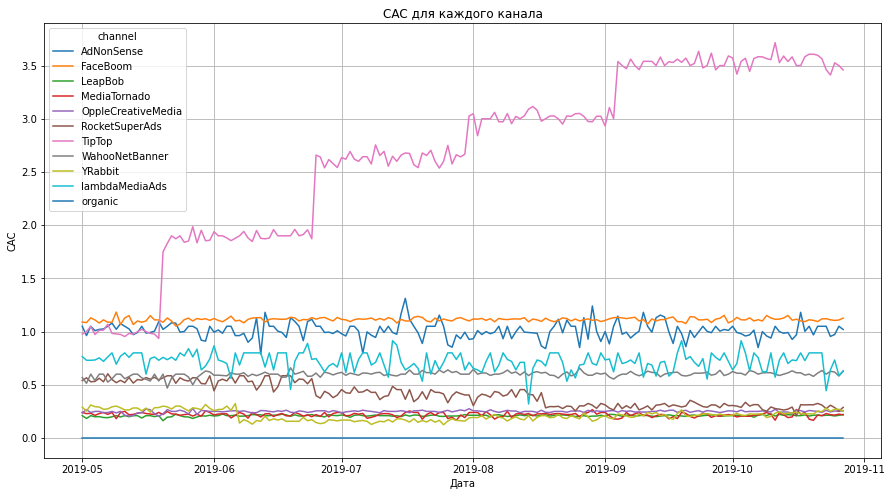

In [36]:
channel_cac_by_date = (
    profiles
    .pivot_table(index='date', columns='channel', values='acquisition_cost', aggfunc='first')
)

plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 1, 1)
channel_cac_by_date.plot(grid=True, ax=ax)
ax.set_xlabel('Дата')
ax.set_ylabel('CAC')
ax.set_title('CAC для каждого канала');

CAC резко вырос 4 раза за 5 месяцев по каналу TipTop. Немного снизизились затраты на одного пользователя для каналов RocketSuperAds и YRabbit. У остальных каналов CAC держался на одном и том же уровне.

## Оценка окупаемости рекламы <a name='advertising_evaluation'><a/>

In [37]:
observation_date = datetime(2019, 11, 1).date()

### Окупаемость рекламы <a name='roi'></a>

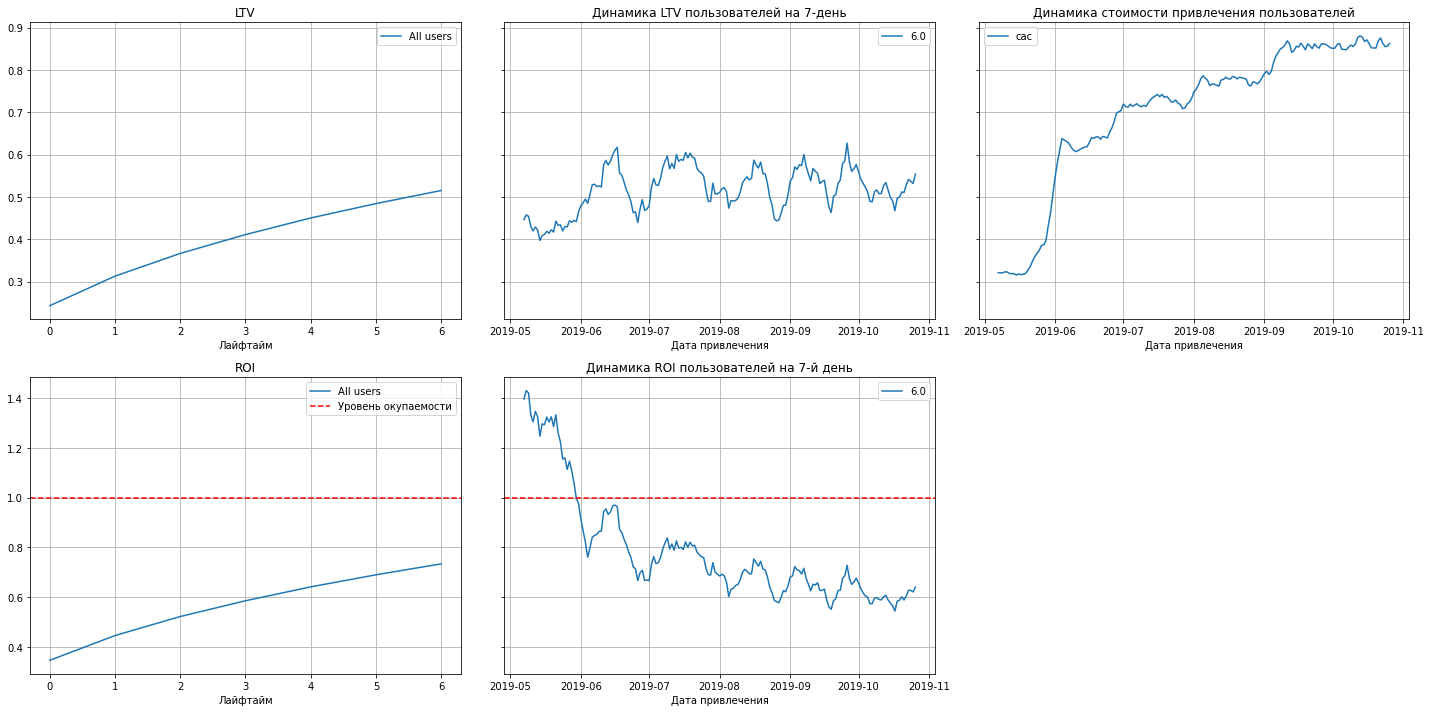

In [38]:
_, ltv, ltv_history, roi, roi_history = get_ltv_and_roi(profiles, orders, observation_date, 7)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 7, 7)

LTV стабилен, а CAC растет со времнем, в итоге реклама не окупается с июня.

### Окупаемость рекламы с разбивкой по устройствам <a name='roi_by_device'></a>

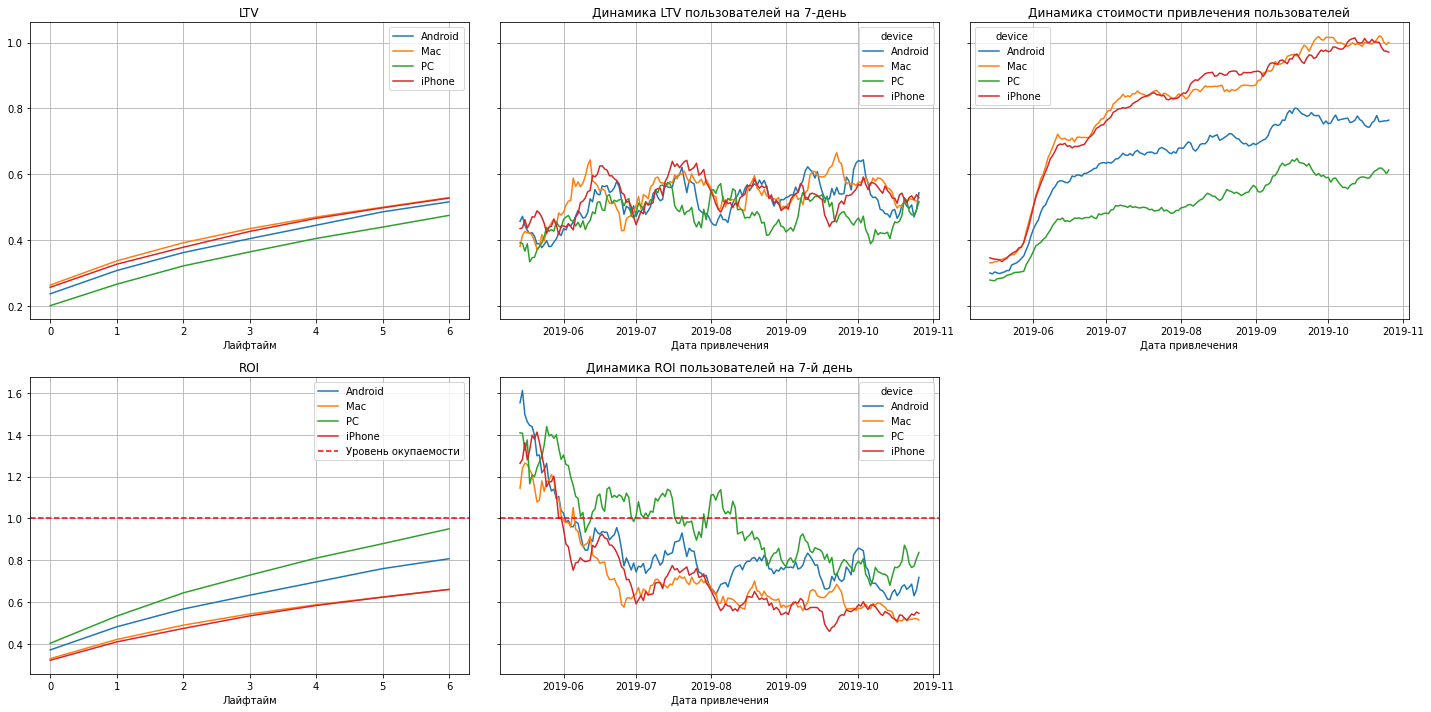

In [39]:
_, ltv_by_device, ltv_history_by_device, roi_by_device, roi_history_by_device = get_ltv_and_roi(
    profiles, orders, observation_date, 7, ['device']
)

plot_ltv_roi(ltv_by_device, ltv_history_by_device, roi_by_device, roi_history_by_device, 7, 14)

Реклама не окупается с какого бы устройстав ни пришел пользователь.

### Окупаемость рекламы с разбивкой по странам <a name='roi_by_country'></a>

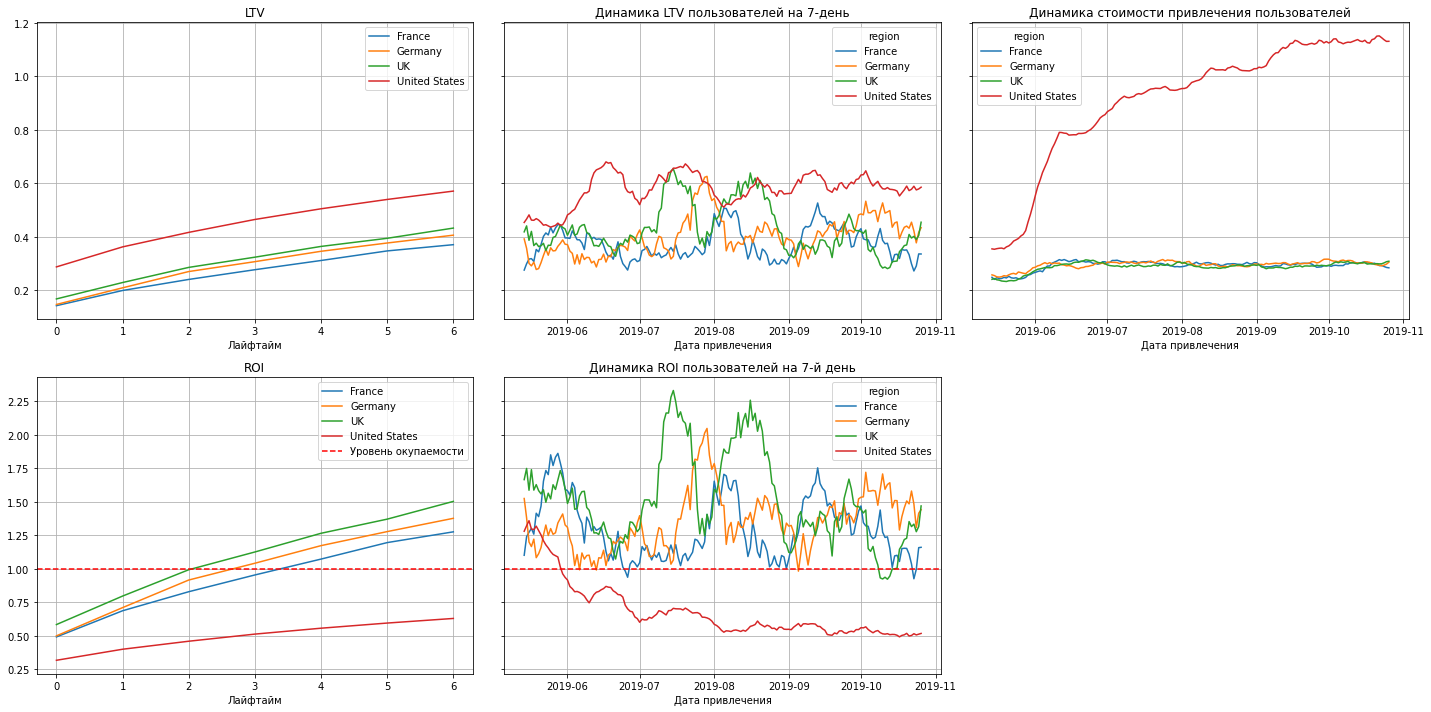

In [40]:
_, ltv_by_region, ltv_history_by_region, roi_by_region, roi_history_by_region = get_ltv_and_roi(
    profiles, orders, observation_date, 7, ['region']
)

plot_ltv_roi(ltv_by_region, ltv_history_by_region, roi_by_region, roi_history_by_region, 7, 14)

Реклама окупается везде, кроме США. У США стабильно самый высокий LTV и в то же время самые большие и продолжающиеся увеличиваться траты на привлечение пользователя.

### Окупаемость рекламы с разбивкой по рекламным каналам <a name='roi_by_channel'></a>

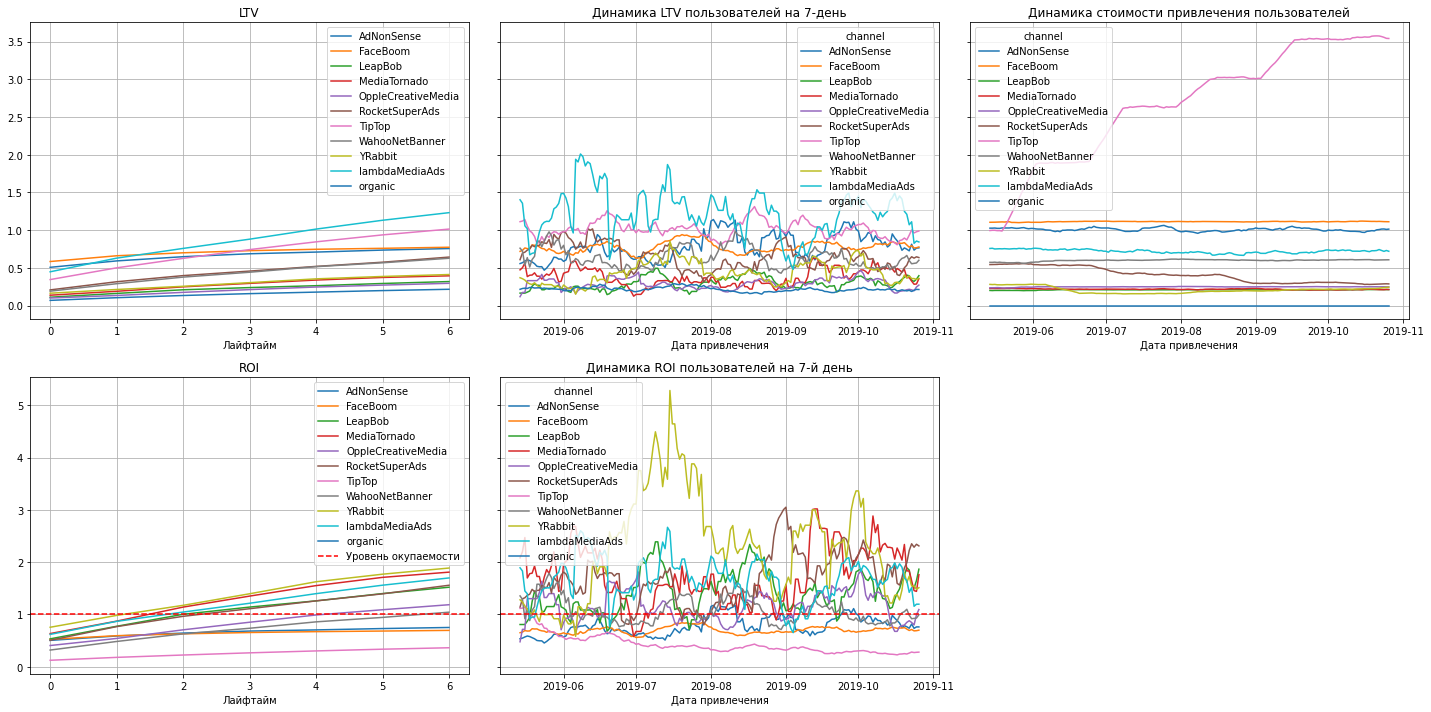

In [41]:
_, ltv_by_channel, ltv_history_by_channel, roi_by_channel, roi_history_by_channel = get_ltv_and_roi(
    profiles, orders, observation_date, 7, ['channel']
)

plot_ltv_roi(ltv_by_channel, ltv_history_by_channel, roi_by_channel, roi_history_by_channel, 7, 14)

* Хуже всего окупаются каналы TipTop и FaceBoom, на которые уходит основная часть бюджета

* У по каналов YRabbit и RocketSuperAds есть несколько всплесков ROI за счет одновременного увеличения LTV и снижения CAC

### Конверсия и удержание <a name='c_r'></a>

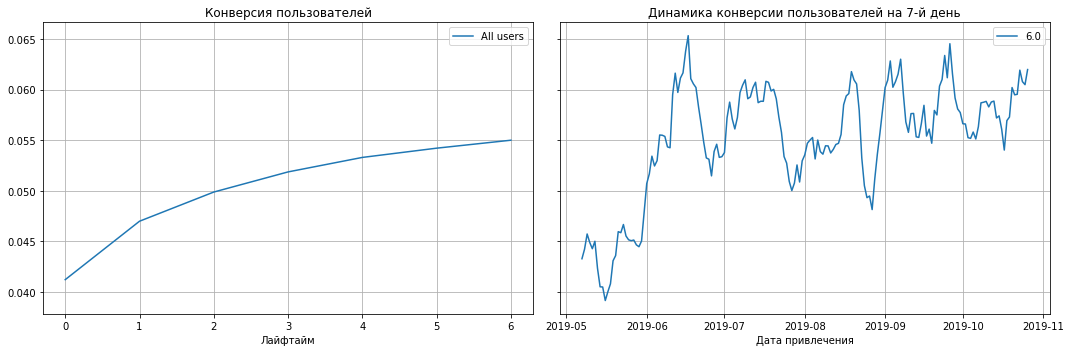

In [42]:
_, conversion, conversion_history = get_conversion(profiles, orders, observation_date, 7)

plot_conversion(conversion, conversion_history, 7, 7)

* Конверсия на 7 день составляет примерно 5.5%

* С мая по июнь конверсия резко выросла. Дальше конверсия постоянно менялась в границах от 5% и 6.5%

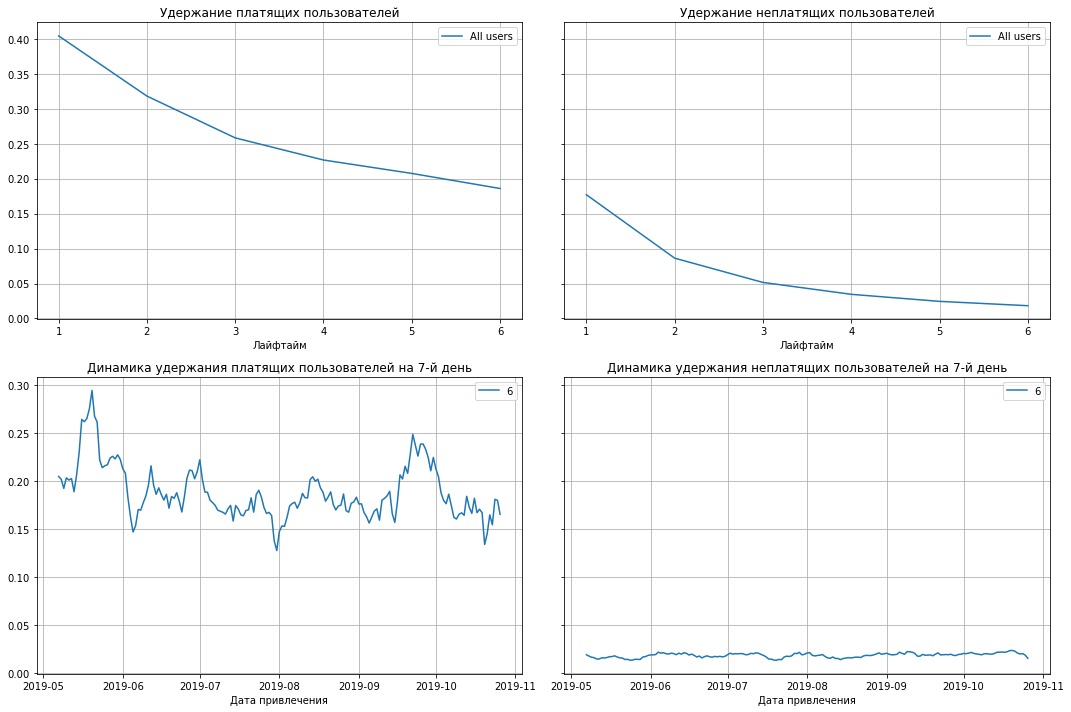

In [43]:
_, retention, retention_history = get_retention(profiles, visits, observation_date, 7)
plot_retention(retention, retention_history, 7, 7)

* Удержание 2 дня неплатящих пользователей равно удержанию 7 дня платящих пользователей

* Видна небольшая отрицательная динамика удержания платящих пользователей на 7 день 

### Конверсия и удержание с разбивкой по устройствам <a name='c_r_by_device'></a>

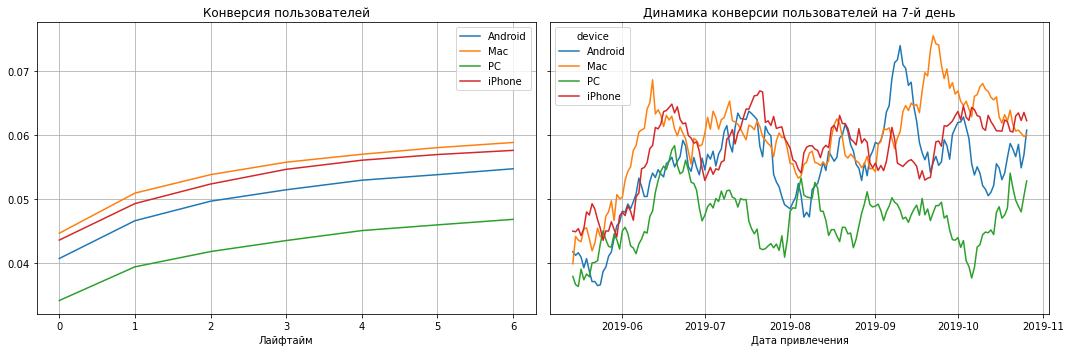

In [44]:
_, conversion_by_device, conversion_history_by_device = get_conversion(
    profiles, orders, observation_date, 7, ['device']
)

plot_conversion(conversion_by_device, conversion_history_by_device, 7, 14)

У пользователей устройств Apple лучшая конверсия, а у пользователей PC – худщая.

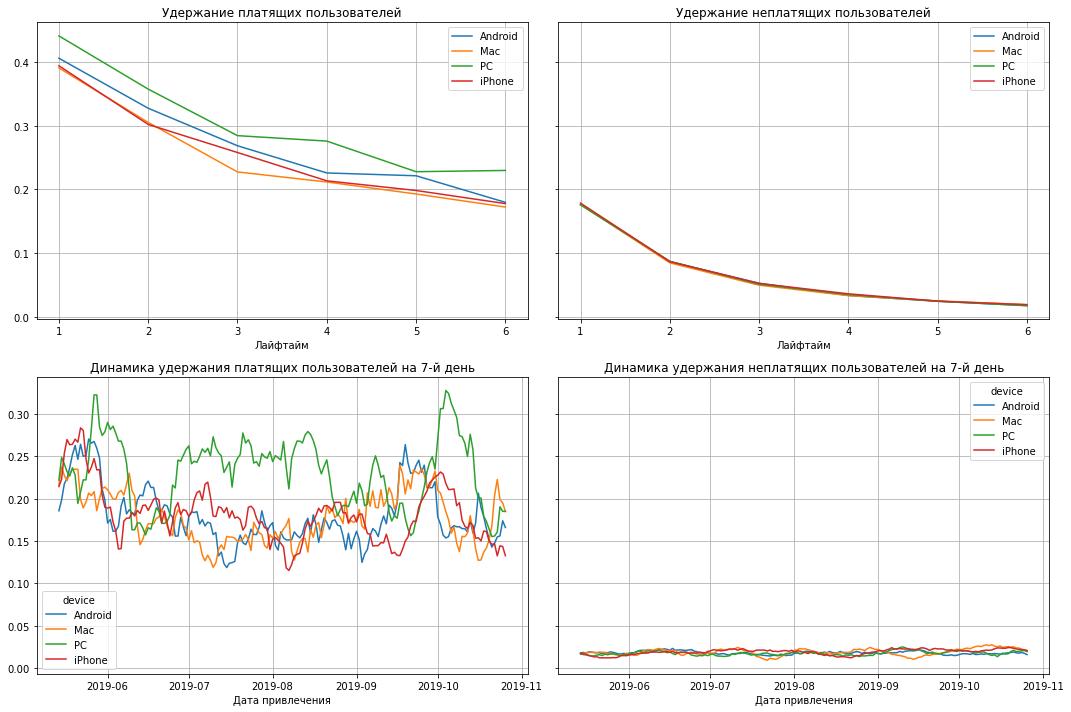

In [45]:
_, retention_by_device, retention_history_by_device = get_retention(
    profiles, visits, observation_date, 7, ['device']
)
plot_retention(retention_by_device, retention_history_by_device, 7, 14)

* В то же время платящие пользователи с устройством PC удерживаются немного лучше, чем пользователи устройств Apple

* Удержание неплатящих пользователей никак не зависит от типа устройства пользователя

### Конверсия и удержание с разбивкой по старнам <a name='c_r_by_country'></a>

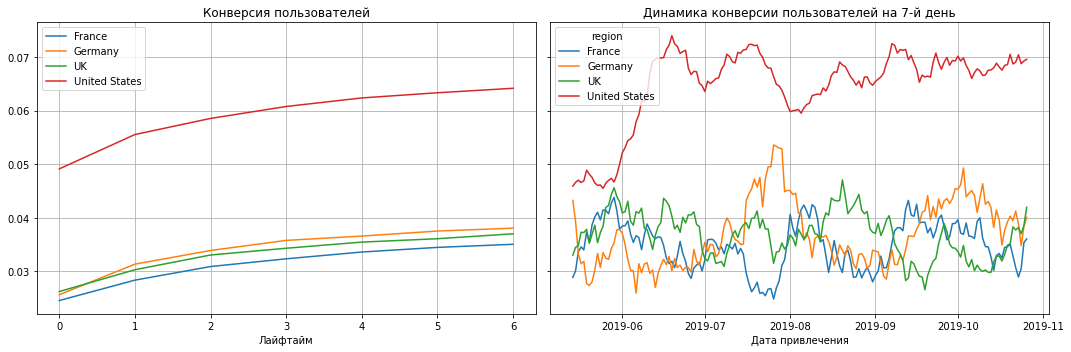

In [46]:
_, conversion_by_region, conversion_history_by_region = get_conversion(
    profiles, orders, observation_date, 7, ['region']
)

plot_conversion(conversion_by_region, conversion_history_by_region, 7, 14)

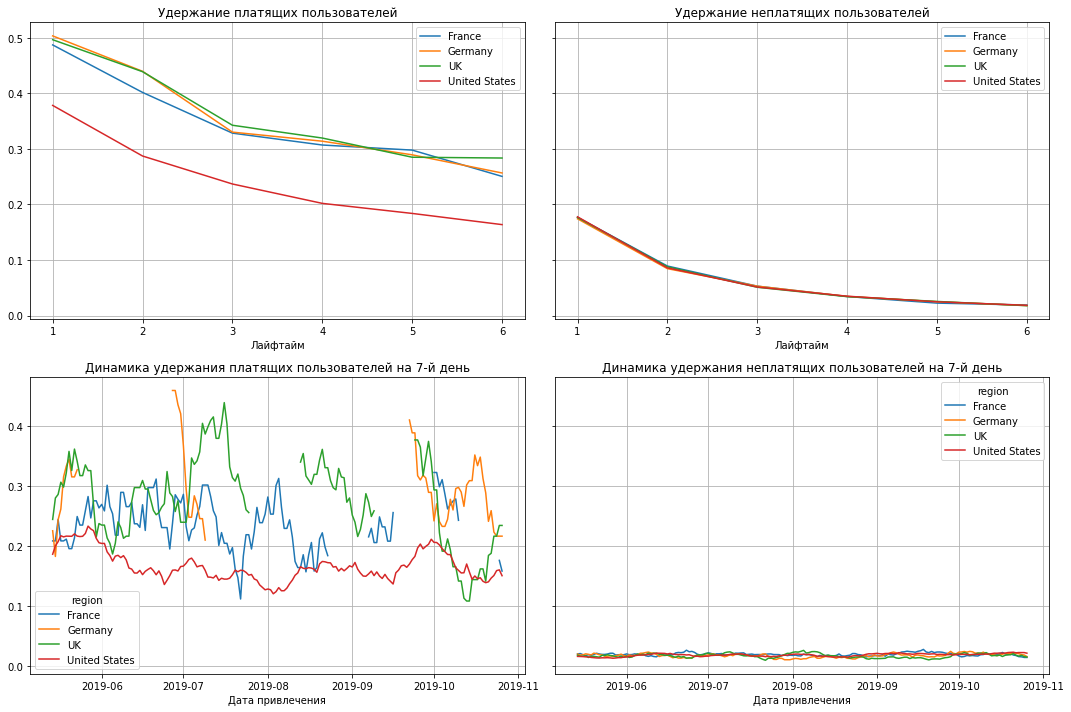

In [47]:
_, retention_by_region, retention_history_by_region = get_retention(
    profiles, visits, observation_date, 7, ['region']
)
plot_retention(retention_by_region, retention_history_by_region, 7, 14)

* Пользователи из США чаще конвертируются и реже удерживаются. Конверсия стабильно держалась на одном уровне после резкого увеличения в июне. Динамика удержания была на одном и том же уровне. 

* Конверсия и удержание неплатящих пользователей не зависит от страны

### Конверсия и удержание с разбивкой по рекламным каналам <a name='c_r_by_channel'></a>

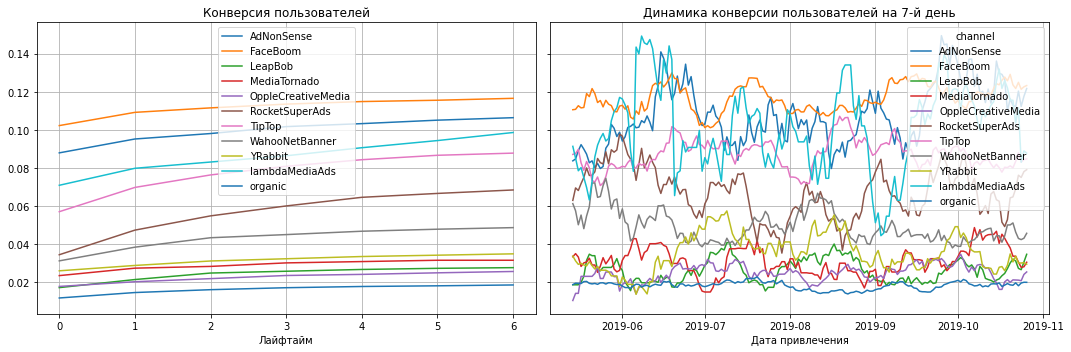

In [48]:
_, conversion_by_channel, conversion_history_by_channel = get_conversion(
    profiles, orders, observation_date, 7, ['channel']
)

plot_conversion(conversion_by_channel, conversion_history_by_channel, 7, 14)

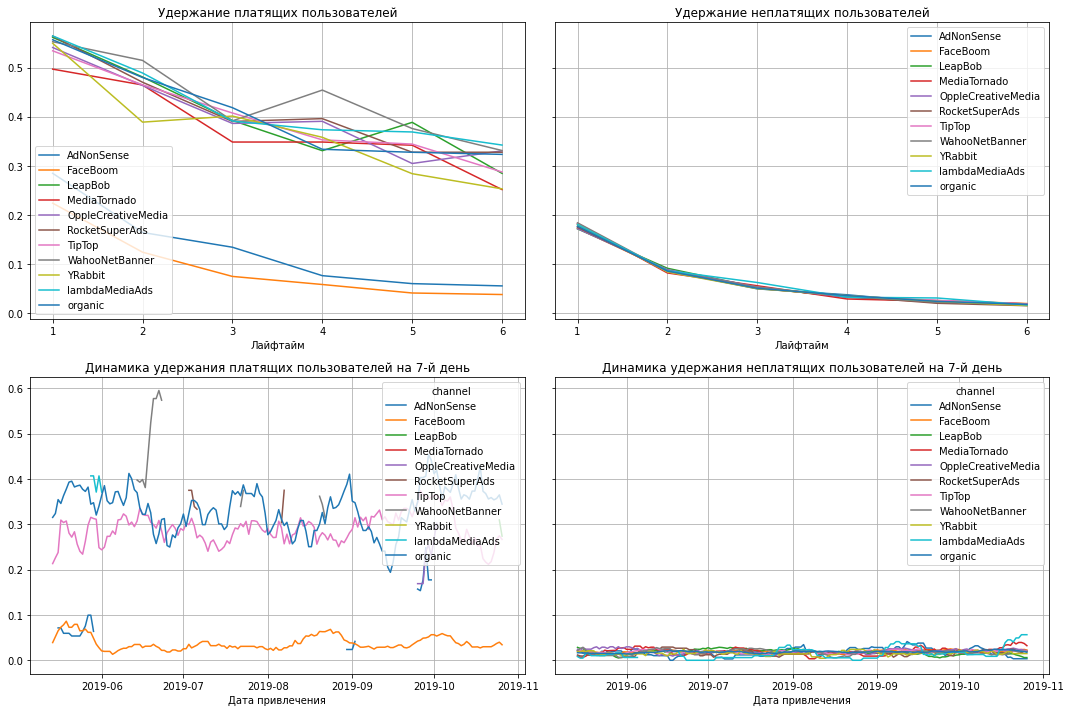

In [49]:
_, retention_by_channel, retention_history_by_channel = get_retention(
    profiles, visits, observation_date, 7, ['channel']
)
plot_retention(retention_by_channel, retention_history_by_channel, 7, 14)

* У канала FaceBoom самая высокая конверсия и самое низкое удержание. Через канал TipTop конвертируются реже, зато пользователи чаще удерживаются. Конверсия и удержание стабильны в течение 5 месяцев для обоих каналов

* Нет никакой зависимости конверсии и удержания неплатящих пользователей от канала привлечения

### Окупаемость рекламых каналов в США <a name='USA'></a>

Подробнее рассмотрим окупаемость рекламных каналов в США, так как только у этой страны ROI 7 дня меньше 1.

In [50]:
profiles_USA = profiles[profiles['region'] == 'United States']
orders_USA = orders[orders['user_id'].isin(profiles_USA['user_id'].unique())]
visits_USA = visits[visits['region'] == 'United States']

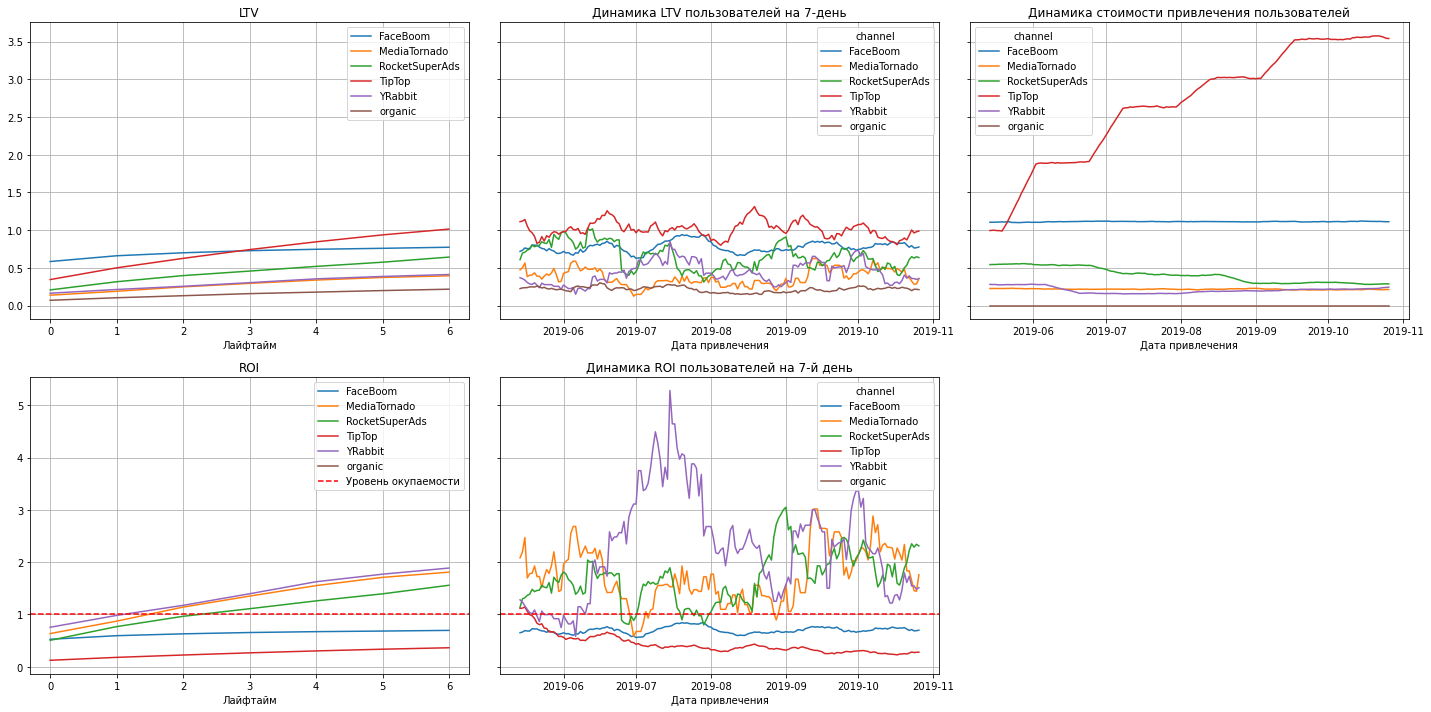

In [51]:
_, ltv_USA_by_channel, ltv_history_USA_by_channel, \
roi_USA_by_channel, roi_history_USA_by_channel = get_ltv_and_roi(
    profiles_USA, orders_USA, observation_date, 7, ['channel']
)

plot_ltv_roi(
    ltv_USA_by_channel, ltv_history_USA_by_channel, 
    roi_USA_by_channel, roi_history_USA_by_channel, 
    7, 14
)

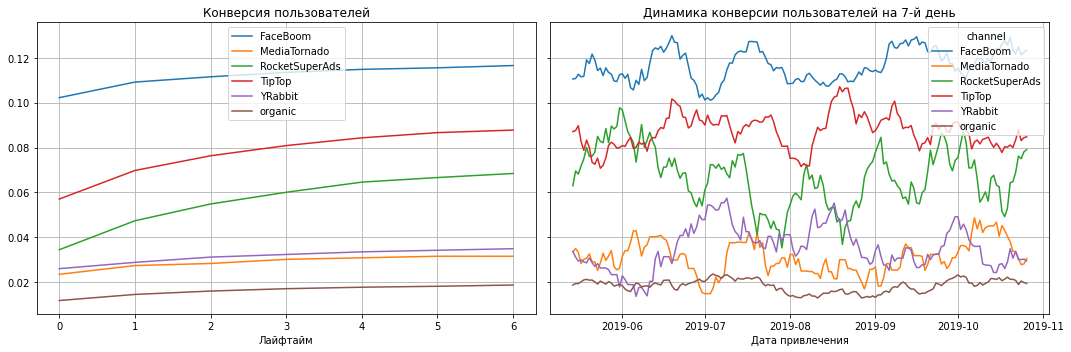

In [52]:
_, conversion_USA_by_channel, conversion_USA_history_by_channel = get_conversion(
    profiles_USA, orders_USA, observation_date, 7, ['channel']
)

plot_conversion(conversion_USA_by_channel, conversion_USA_history_by_channel, 7, 14)

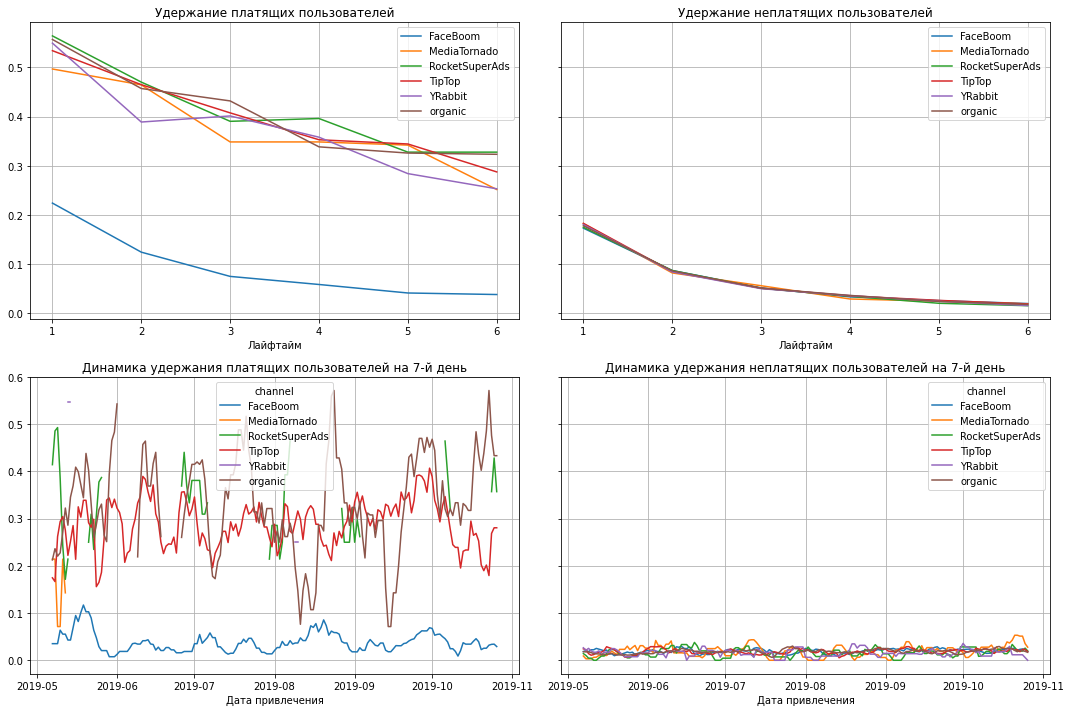

In [53]:
_, retention_USA_by_channel, retention_USA_history_by_channel = get_retention(
    profiles_USA, visits_USA, observation_date, 7, ['channel']
)
plot_retention(retention_USA_by_channel, retention_USA_history_by_channel, 7, 7)

Исходя из графиков LTV, CAC, ROI, конверсии и удержания, стоит перерапределить часть бюджета неокупаемых каналов TipTop и FaceBoom в пользу окупаемых RocketSuperAds, YRabbit и MediaTornado.

## Вывод <a name='conclusion'></a>

Неокупается привлечение американских пользователей через каналы TipTop и FaceBoom. Для улучшения ситуации стоит перерапределить часть бюджета неокупаемых каналов TipTop и FaceBoom в пользу окупаемых RocketSuperAds, YRabbit и MediaTornado. Выгоднее распределить бюджет между окупаемыми каналами в зависмости от их эффективности: чем больше эффективность, тем больше расходы на рекламу. По эффективности каналы распределены следующим образом: RocketSuperAds, YRabbit и MediaTornado.